<a href="https://colab.research.google.com/github/aymenhmid/fastai_course/blob/main/Fast_ai_Machine_Learning_Lesson1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Modern Random Forest Implementation - Bulldozer Dataset
# Updated version of Fast.ai ML Course Lesson 1
# Using current best practices and libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configuration
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [ ]:
class BulldozerDataProcessor:
    """Modern data processor for the bulldozer dataset"""

    def __init__(self):
        self.label_encoders = {}
        self.na_dict = {}

    def add_datepart(self, df, field_name):
        """Extract date features from datetime column"""
        field = df[field_name]
        if not pd.api.types.is_datetime64_any_dtype(field):
            field = pd.to_datetime(field, infer_datetime_format=True)

        # Extract date components
        attrs = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']

        for attr in attrs:
            if attr == 'Week':
                df[field_name + attr] = field.dt.isocalendar().week
            else:
                df[field_name + attr] = getattr(field.dt, attr.lower())

        # Remove original date column
        df.drop(field_name, axis=1, inplace=True)

        return df

    def process_categorical_columns(self, df):
        """Convert categorical columns to numeric using label encoding"""
        categorical_columns = df.select_dtypes(include=['object']).columns

        for col in categorical_columns:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                # Handle missing values
                df[col] = df[col].fillna('missing')
                self.label_encoders[col].fit(df[col])

            df[col] = self.label_encoders[col].transform(df[col])

        return df

    def handle_missing_values(self, df):
        """Handle missing values in numeric columns"""
        numeric_columns = df.select_dtypes(include=[np.number]).columns

        for col in numeric_columns:
            if df[col].isnull().any():
                # Store median for future use
                if col not in self.na_dict:
                    self.na_dict[col] = df[col].median()
                # Fill missing values with median
                df[col].fillna(self.na_dict[col], inplace=True)

        return df

    def process_data(self, df, target_col=None, is_training=True):
        """Main data processing pipeline"""
        df = df.copy()

        # Handle target variable
        if target_col and target_col in df.columns:
            # Take log of target for RMSLE metric
            df[target_col] = np.log(df[target_col])
            y = df[target_col]
            df.drop(target_col, axis=1, inplace=True)
        else:
            y = None

        # Process date columns
        date_columns = df.select_dtypes(include=['datetime64']).columns
        for col in date_columns:
            df = self.add_datepart(df, col)

        # Process categorical columns
        df = self.process_categorical_columns(df)

        # Handle missing values
        df = self.handle_missing_values(df)

        return df, y

In [ ]:
def create_validation_set(df, y, validation_size=12000):
    """Create validation set based on time (similar to original approach)"""
    # Use last 12000 samples as validation (similar to Kaggle setup)
    n_train = len(df) - validation_size

    X_train = df.iloc[:n_train].copy()
    X_valid = df.iloc[n_train:].copy()
    y_train = y.iloc[:n_train].copy()
    y_valid = y.iloc[n_train:].copy()

    return X_train, X_valid, y_train, y_valid

def rmse(y_true, y_pred):
    """Calculate Root Mean Square Error"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def print_scores(model, X_train, y_train, X_valid, y_valid):
    """Print comprehensive model scores"""
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)

    train_rmse = rmse(y_train, train_pred)
    valid_rmse = rmse(y_valid, valid_pred)
    train_r2 = r2_score(y_train, train_pred)
    valid_r2 = r2_score(y_valid, valid_pred)

    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {valid_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Validation R²: {valid_r2:.4f}")

    if hasattr(model, 'oob_score_'):
        print(f"OOB Score: {model.oob_score_:.4f}")

    return {
        'train_rmse': train_rmse,
        'valid_rmse': valid_rmse,
        'train_r2': train_r2,
        'valid_r2': valid_r2,
        'oob_score': getattr(model, 'oob_score_', None)
    }

def plot_feature_importance(model, feature_names, top_n=20):
    """Plot feature importance"""
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance_df.head(top_n), x='importance', y='feature')
        plt.title(f'Top {top_n} Feature Importances')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

        return importance_df
    else:
        print("Model doesn't have feature_importances_ attribute")
        return None

def hyperparameter_tuning(X_train, y_train, X_valid, y_valid):
    """Simple hyperparameter tuning"""
    results = []

    # Test different parameter combinations
    param_combinations = [
        {'n_estimators': 40, 'max_depth': None, 'min_samples_leaf': 1, 'max_features': 'sqrt'},
        {'n_estimators': 40, 'max_depth': None, 'min_samples_leaf': 3, 'max_features': 'sqrt'},
        {'n_estimators': 40, 'max_depth': None, 'min_samples_leaf': 5, 'max_features': 'sqrt'},
        {'n_estimators': 40, 'max_depth': 20, 'min_samples_leaf': 3, 'max_features': 0.5},
        {'n_estimators': 80, 'max_depth': None, 'min_samples_leaf': 3, 'max_features': 0.5},
    ]

    for i, params in enumerate(param_combinations):
        print(f"\nTesting combination {i+1}: {params}")

        model = RandomForestRegressor(
            random_state=42,
            n_jobs=-1,
            oob_score=True,
            **params
        )

        model.fit(X_train, y_train)
        scores = print_scores(model, X_train, y_train, X_valid, y_valid)

        results.append({
            'params': params,
            'scores': scores
        })

    return results

Modern Random Forest Implementation - Bulldozer Dataset
Processing data...
Training set shape: (389125, 57)
Validation set shape: (12000, 57)

1. Basic Random Forest
------------------------------
Training RMSE: 0.0794
Validation RMSE: 0.2395
Training R²: 0.9868
Validation R²: 0.8976
OOB Score: 0.9063

2. Improved Random Forest
------------------------------
Training RMSE: 0.1504
Validation RMSE: 0.2316
Training R²: 0.9527
Validation R²: 0.9042
OOB Score: 0.9090

3. Feature Importance Analysis
------------------------------


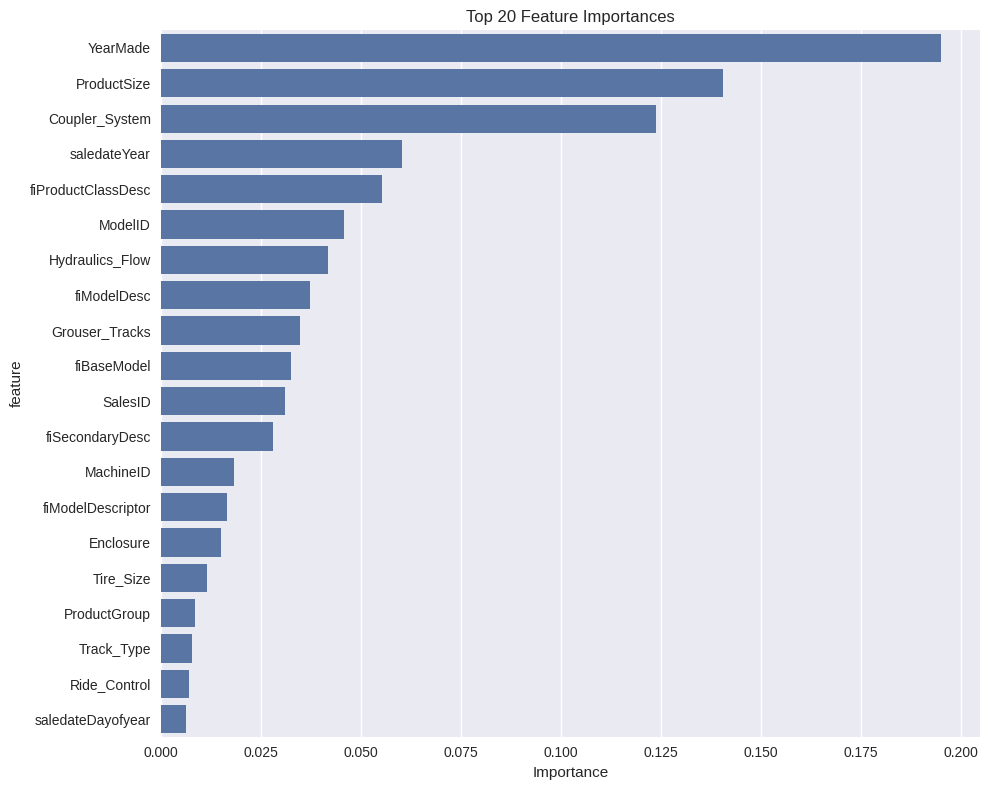


4. Hyperparameter Tuning
------------------------------

Testing combination 1: {'n_estimators': 40, 'max_depth': None, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Training RMSE: 0.0844
Validation RMSE: 0.2531
Training R²: 0.9851
Validation R²: 0.8856
OOB Score: 0.8939

Testing combination 2: {'n_estimators': 40, 'max_depth': None, 'min_samples_leaf': 3, 'max_features': 'sqrt'}
Training RMSE: 0.1666
Validation RMSE: 0.2573
Training R²: 0.9420
Validation R²: 0.8818
OOB Score: 0.8856

Testing combination 3: {'n_estimators': 40, 'max_depth': None, 'min_samples_leaf': 5, 'max_features': 'sqrt'}
Training RMSE: 0.1936
Validation RMSE: 0.2605
Training R²: 0.9217
Validation R²: 0.8788
OOB Score: 0.8799

Testing combination 4: {'n_estimators': 40, 'max_depth': 20, 'min_samples_leaf': 3, 'max_features': 0.5}
Training RMSE: 0.1517
Validation RMSE: 0.2340
Training R²: 0.9519
Validation R²: 0.9022
OOB Score: 0.9061

Testing combination 5: {'n_estimators': 80, 'max_depth': None, 'min_samples_lea

In [ ]:
if __name__ == "__main__":
    print("Modern Random Forest Implementation - Bulldozer Dataset")
    print("=" * 60)

    # Note: You'll need to load your data here
    # For demonstration, I'll show how to use the processor

    # Example usage (uncomment when you have the data):

    # Load data
    df_raw = pd.read_csv('/content/drive/MyDrive/bluebook-for-bulldozers/Train.csv', low_memory=False, parse_dates=['saledate'])

    # Initialize processor
    processor = BulldozerDataProcessor()

    # Process data
    print("Processing data...")
    df_processed, y = processor.process_data(df_raw, target_col='SalePrice')

    # Create validation set
    X_train, X_valid, y_train, y_valid = create_validation_set(df_processed, y)

    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_valid.shape}")

    # Basic Random Forest
    print("\n1. Basic Random Forest")
    print("-" * 30)
    rf_basic = RandomForestRegressor(
        n_estimators=40,
        random_state=42,
        n_jobs=-1,
        oob_score=True
    )
    rf_basic.fit(X_train, y_train)
    print_scores(rf_basic, X_train, y_train, X_valid, y_valid)

    # Improved Random Forest
    print("\n2. Improved Random Forest")
    print("-" * 30)
    rf_improved = RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_leaf=3,
        max_features=0.5,
        random_state=42,
        n_jobs=-1,
        oob_score=True
    )
    rf_improved.fit(X_train, y_train)
    print_scores(rf_improved, X_train, y_train, X_valid, y_valid)

    # Feature importance
    print("\n3. Feature Importance Analysis")
    print("-" * 30)
    feature_importance = plot_feature_importance(rf_improved, X_train.columns)

    # Hyperparameter tuning
    print("\n4. Hyperparameter Tuning")
    print("-" * 30)
    tuning_results = hyperparameter_tuning(X_train, y_train, X_valid, y_valid)

    # Find best parameters
    best_result = min(tuning_results, key=lambda x: x['scores']['valid_rmse'])
    print(f"\nBest parameters: {best_result['params']}")
    print(f"Best validation RMSE: {best_result['scores']['valid_rmse']:.4f}")


    print("\nTo use this notebook:")
    print("1. Load your bulldozer dataset")
    print("2. Uncomment the main execution code")
    print("3. Run the cells to see the results")
    print("\nKey improvements over the original notebook:")
    print("- Uses modern sklearn APIs")
    print("- Better error handling")
    print("- More comprehensive evaluation")
    print("- Cleaner code structure")
    print("- Modern visualization")